In [39]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])



In [40]:
# Load solution
plate_size = 100 # mm
data_dir = "../data_fem"
data_name = f"{int(plate_size)}x{int(plate_size)}mm"
data_path = f"{data_dir}/{data_name}"

data = np.loadtxt(data_path+".dat", delimiter=" ")
X_val = data[:, :2]
u_val = data[:, 2:4]
strain_val = data[:, 4:7]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, strain_val))

n_mesh_points = int(np.sqrt(X_val.shape[0]))

# Interpolate solution
x_grid = np.linspace(0, plate_size, n_mesh_points)
y_grid = np.linspace(0, plate_size, n_mesh_points)

def create_interpolation_fn(data_array):
    num_components = data_array.shape[1]
    interpolators = []
    for i in range(num_components):
        interp = RegularGridInterpolator(
            (x_grid, y_grid),
            data_array[:, i].reshape(n_mesh_points, n_mesh_points).T,
        )
        interpolators.append(interp)
    def interpolation_fn(x1,x2):
        return np.array([interp((x1, x2)) for interp in interpolators]).T
    return interpolation_fn

solution_fn = create_interpolation_fn(solution_val)
strain_fn   = create_interpolation_fn(strain_val)


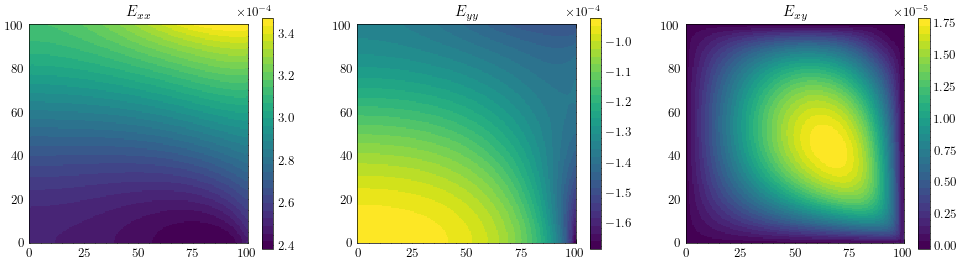

In [72]:
# Check interpolation

def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'on',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 30
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

n_plot_points = 177
x_plot = np.linspace(0, plate_size, n_plot_points)
y_plot = np.linspace(0, plate_size, n_plot_points)
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

strain_plot = strain_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X, Y, strain_plot[:,0].reshape(X.shape), r"$E_{xx}$",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_plot[:,1].reshape(X.shape), r"$E_{yy}$",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_plot[:,2].reshape(X.shape), r"$E_{xy}$",colormap=cmap)

## Strain reconstruction

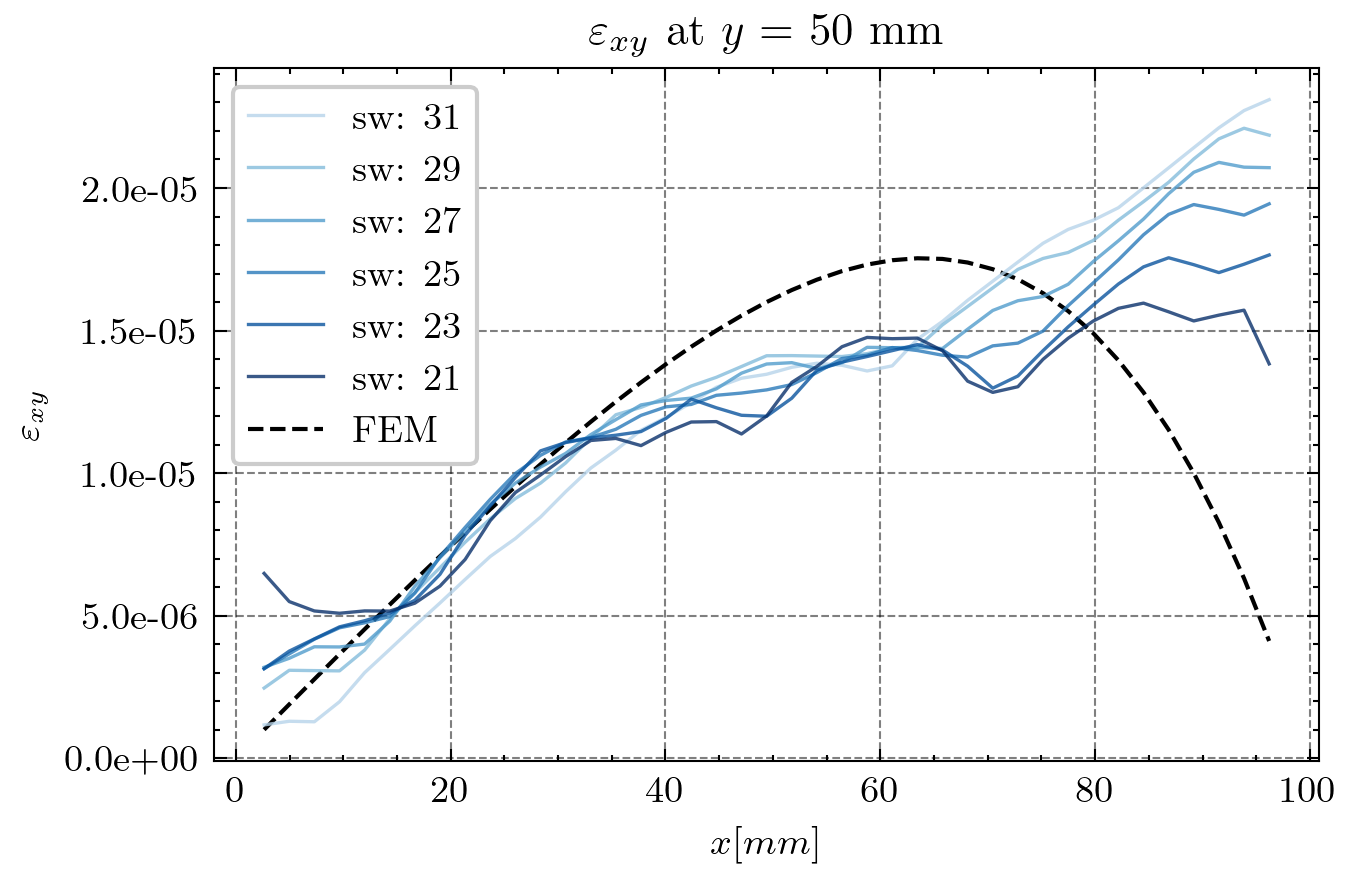

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set matplotlib font size

font_factor = 1.5
title_font_size = 6
axes_font_size = 6
figure_factor = 1.5
plt.rcParams.update({
    "font.size": title_font_size*font_factor,         # Default font size for all text
    "figure.titlesize": title_font_size*font_factor, 
    "axes.labelsize": axes_font_size*font_factor,
    "xtick.labelsize": axes_font_size*font_factor,
    "ytick.labelsize": axes_font_size*font_factor,
    "legend.fontsize": axes_font_size*font_factor,
})

def plot_field_slice(ax, base_folder, field_name, y_slice):
    """
    Plots a specified field at a given relative height position.
    
    Parameters:
    - base_folder (str): Path to the folder containing the data.
    - field_name (str): Name of the field to plot (e.g., 'exy').
    - y_slice (float): Relative height position (0 to 1, where 0 is bottom and 1 is top).
    """
    # Load X and Y coordinates
    x_coords = pd.read_csv(os.path.join(base_folder, "x.csv"), delimiter=";").dropna(axis=1).to_numpy()
    y_coords = pd.read_csv(os.path.join(base_folder, "y.csv"), delimiter=";").dropna(axis=1).to_numpy()
    
    # Determine the index corresponding to the given relative height
    y_mid_index = np.abs(y_coords[:, 0] - y_slice).argmin()
    
    # Load the field data
    field_data = {}
    for folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            try:
                sw_value = int(folder)  # Extract SW value from folder name
                
                # Search for the corresponding field file
                for file in os.listdir(folder_path):
                    if file.startswith(field_name) and file.endswith(".csv"):
                        data_path = os.path.join(folder_path, file)
                        field_data[sw_value] = pd.read_csv(data_path, delimiter=";").dropna(axis=1).to_numpy()
            except ValueError:
                continue  # Skip non-numeric folder names
    
    # Sort by SW in descending order
    sorted_sw = sorted(field_data.keys(), reverse=True)
    
    # Prepare the figure
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_sw)))
    
    # Plot each SW
    for i, sw in enumerate(sorted_sw):
        ax.plot(x_coords[y_mid_index, :], field_data[sw][y_mid_index, :], label=f"sw: {sw}", color=colors[i], linewidth=0.8, alpha=0.8)
    
    return ax, x_coords, y_coords, y_mid_index, sorted_sw

field_id = 2
camera_id = 2
y_slice = 50

camera_resolution = ["5MP","2MP","0.4MP"][camera_id]
measurments_str = ['192x191', '115x114', '41x39'][camera_id]

base_folder = f"data_VSG_study/{camera_resolution}/"
field_name = ["exx", "eyy", "exy"][field_id]

fig, ax = plt.subplots(figsize=(3.17*figure_factor, 2*figure_factor), dpi=300) # 3.17 inches = half A4 with margins
ax, x_coords, y_coords, y_mid_index, sorted_sw = plot_field_slice(ax, base_folder, field_name, y_slice)

# Plot PINN reconstruction
if False:
    noise, time, run_number = 1, 5, 1
    results_folder, dic_prefix = "results", "dic_"
    run = f"{dic_prefix}displacement_{measurments_str}_{noise}noise_{time}min{f'-{run_number}' if run_number else ''}"
    run_folder = os.path.join(results_folder, f"{noise}noise", run) + "/"

    def read_data_file(filename):
        with open(filename, "r") as f:
            data = [line.split(' ', 1) for line in f]
        steps, values = zip(*[(eval(s), eval(v)) for s, v in data])
        return list(steps), list(values)

    fields = [np.array(read_data_file(os.path.join(run_folder, f"{name}_history.dat"))[1]) for name in ["Exx", "Eyy", "Exy"]]
    total_loss = np.mean(np.loadtxt(os.path.join(run_folder, "loss_history.dat"))[:, 1:], axis=1)
    min_loss_idx = np.argmin(total_loss)
    field = np.array(fields[field_id][min_loss_idx]).reshape([100, 100]).T
    x_pinn = np.linspace(0, plate_size, 100)[1:-1]
    y_pinn = np.linspace(0, plate_size, 100)
    y_pinn_index = np.abs(y_pinn - y_slice).argmin()
    ax.plot(x_pinn, field[y_pinn_index, 1:-1], label="PINN", color='r', linewidth=1, alpha=0.8, zorder=-1)

# Plot FEM comparison at the end
ax.plot(x_coords[y_mid_index, :], strain_fn(x_coords[y_mid_index, :], y_coords[y_mid_index, :])[:, field_id], 'k--', label="FEM", linewidth=1, zorder=-2)

# Plot legend and labels
ax.legend()
ax.set_xlabel(r"$x [mm]$")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))
ax.set_ylabel([r'$\varepsilon_{xx}$', r'$\varepsilon_{yy}$', r'$\varepsilon_{xy}$'][field_id])
ax.set_title(f"{[r'$\varepsilon_{xx}$', r'$\varepsilon_{yy}$', r'$\varepsilon_{xy}$'][field_id]} at $y$ = {y_slice} mm")
plt.show()

# fig.savefig(f"figures/{camera_resolution}_{field_name}_slice_y_{y_slice}mm.png", dpi=300, bbox_inches='tight')

In [239]:
fig.savefig(f"figures/{camera_resolution}_{field_name}_slice_y_{y_slice}mm.png", dpi=300, bbox_inches='tight')

In [43]:
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import os


camera_resolution = ["5MP","2MP","0.4MP"][0]
noise = 0
base_folder = f"data_dic/{camera_resolution}/{noise}noise/"

def load_dic_fields(base_folder, dic_number=None):
    dic_number_str = f"_{dic_number}" if dic_number else ""
    X_dic = pd.read_csv(os.path.join(base_folder, "x", f"x{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    Y_dic = pd.read_csv(os.path.join(base_folder, "y", f"y{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    Ux_dic = pd.read_csv(os.path.join(base_folder, "ux", f"ux{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    Uy_dic = pd.read_csv(os.path.join(base_folder, "uy", f"uy{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    Exx_dic = pd.read_csv(os.path.join(base_folder, "exx", f"exx{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    Eyy_dic = pd.read_csv(os.path.join(base_folder, "eyy", f"eyy{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    Exy_dic = pd.read_csv(os.path.join(base_folder, "exy", f"exy{dic_number_str}.csv"), delimiter=";").dropna(axis=1).to_numpy()
    return X_dic, Y_dic, Ux_dic, Uy_dic, Exx_dic, Eyy_dic, Exy_dic

camera_resolution = ["5MP","2MP","0.4MP"][0]
noise = 0
dic_number = 1
base_folder = f"data_dic/{camera_resolution}/{noise}noise/"

X_dic, Y_dic, Ux_dic, Uy_dic, Exx_dic, Eyy_dic, Exy_dic = load_dic_fields(base_folder, dic_number)
print(f"DIC data loaded, X: {X_dic.shape}, Y: {Y_dic.shape}, Ux: {Ux_dic.shape}, Uy: {Uy_dic.shape}")

noise = 1
base_folder = f"data_dic/{camera_resolution}/{noise}noise/"
X_dic_noise, Y_dic_noise, Ux_dic_noise, Uy_dic_noise, Exx_dic_noise, Eyy_dic_noise, Exy_dic_noise = load_dic_fields(base_folder, dic_number)
print(f"Noisy DIC data loaded, X: {X_dic_noise.shape}, Y: {Y_dic_noise.shape}, Ux: {Ux_dic_noise.shape}, Uy: {Uy_dic_noise.shape}")

# Noise effect on coordinates
print("Noise effect on :\n X: ", np.linalg.norm(X_dic - X_dic_noise), "\n Y: ", np.linalg.norm(Y_dic - Y_dic_noise), "\n Ux: ", np.linalg.norm(Ux_dic - Ux_dic_noise), "\n Uy: ", np.linalg.norm(Uy_dic - Uy_dic_noise))
print("--> Effect on the coordinates")

DIC data loaded, X: (191, 192), Y: (191, 192), Ux: (191, 192), Uy: (191, 192)
Noisy DIC data loaded, X: (191, 192), Y: (191, 192), Ux: (191, 192), Uy: (191, 192)
Noise effect on :
 X:  0.01732195895141329 
 Y:  0.015489574006188772 
 Ux:  0.018852004340778727 
 Uy:  0.015670433698463642
--> Effect on the coordinates


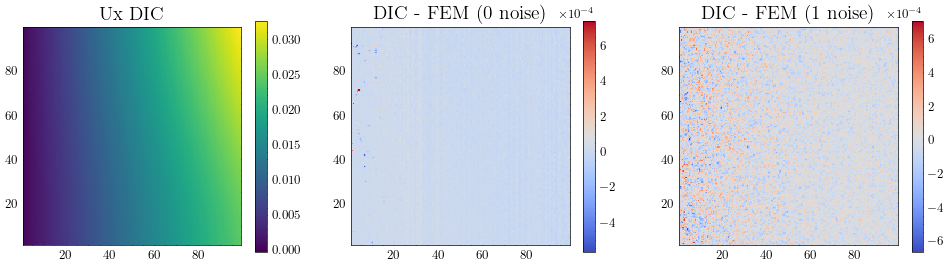

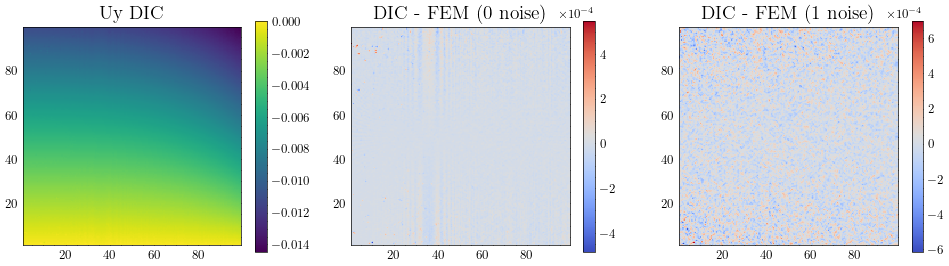

In [44]:
Ux_fem, Uy_fem, Exx_fem, Eyy_fem, Exy_fem = [solution_fn(X_dic, Y_dic)[:,:, i].T for i in range(5)]

# # Plot DIC displacement
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X_dic, Y_dic, Ux_dic, "Ux DIC",colormap="viridis")#, cmin=0, cmax=0.015)
im = pcolor_plot(ax[1], X_dic, Y_dic, Ux_dic-Ux_fem, "DIC - FEM  (0 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)
im = pcolor_plot(ax[2], X_dic, Y_dic, Ux_dic_noise-Ux_fem, "DIC - FEM  (1 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X_dic, Y_dic, Uy_dic, "Uy DIC",colormap="viridis")#, cmin=0, cmax=0.015)
im = pcolor_plot(ax[1], X_dic, Y_dic, Uy_dic-Uy_fem.reshape(X_dic.shape), "DIC - FEM  (0 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)
im = pcolor_plot(ax[2], X_dic, Y_dic, Uy_dic_noise-Uy_fem.reshape(X_dic.shape), "DIC - FEM  (1 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

In [ ]:
# Compute mean and std for each field 10 runs
fields_name = [r"$u_x$", r"$u_y$", r"$\varepsilon_{xx}$", r"$\varepsilon_{yy}$", r"$\varepsilon_{xy}$"]

noise = 1
import matplotlib.colors as colors


def compute_statistics(base_folder):
    dic_numbers = range(1, 10)
    fields = np.stack([load_dic_fields(base_folder, dic_number) for dic_number in dic_numbers], axis=3)
    X_dic, Y_dic = fields[:2, :, :, 0]
    fields = fields[2:, :, :, :]
    fields_fem= np.stack([solution_fn(X_dic, Y_dic)[:,:, i].T for i in range(5)])[:, :, :, np.newaxis]
    # fields_fem = np.stack([Ux_fem, Uy_fem, Exx_fem, Eyy_fem, Exy_fem])[:, :, :, np.newaxis]
    fields_mean = np.mean(fields, axis=3)
    fields_std = np.std(fields, axis=3)
    fields_bias = fields_mean - fields_fem.squeeze(axis=3)
    fields_diff = fields - fields_fem
    fields_std_to_fem = np.mean(fields_diff**2, axis=3)**0.5
    return X_dic, Y_dic, fields_mean, fields_std, fields_bias, fields_std_to_fem

# Plot mean and std
def plot_mean_std(ax,fields_idx, X_dic, Y_dic, fields_mean, fields_std):
    fields_fem= np.stack([solution_fn(X_dic, Y_dic)[:,:, i].T for i in range(5)])[:, :, :]
    im = pcolor_plot(ax[0], X_dic, Y_dic, fields_fem[fields_idx,:,:], f"{fields_name[fields_idx]} FEM",colormap="viridis")#, cmin=0, cmax=0.015) 
    im = pcolor_plot(ax[1], X_dic, Y_dic, fields_mean[fields_idx,:,:], f"{fields_name[fields_idx]} DIC mean",colormap="viridis", cmin=min(fields_fem[fields_idx,:,:].flatten()), cmax=max(fields_fem[fields_idx,:,:].flatten()))
    im = pcolor_plot(ax[2], X_dic, Y_dic, fields_std[fields_idx,:,:], f"{fields_name[fields_idx]} DIC std", colormap="Reds")
    norm_bias = max(np.abs(fields_bias[fields_idx,:,:].flatten()))
    im = pcolor_plot(ax[3], X_dic, Y_dic, fields_bias[fields_idx,:,:], f"{fields_name[fields_idx]} DIC bias",colormap="coolwarm", cmin=-norm_bias, cmax=norm_bias)

def print_stats_table(fields_std, fields_bias, camera_resolution):
    print(f"Table: Statistics for {camera_resolution} camera")
    print("-" * 40)
    print(f"{'Field':<15}{'Std':<15}{'Bias':<15}")
    print("-" * 40)
    for field_idx in range(5):
        print(f"{fields_name[field_idx]:<15}{np.mean(fields_std[field_idx,:,:]):<15.2e}{np.mean(np.abs(fields_bias[field_idx,:,:])):<15.2e}")
    print("-" * 40)

for camera_resolution in ["5MP","2MP","0.4MP"]:
    base_folder = f"data_dic/{camera_resolution}/{noise}noise/"
    X_dic, Y_dic, fields_mean, fields_std, fields_bias, fields_std_to_fem = compute_statistics(base_folder)
    print_stats_table(fields_std, fields_bias, camera_resolution)

    # plot_mean_std(2, X_dic, Y_dic, fields_mean, fields_std)


Table: Statistics for 5MP camera
----------------------------------------
Field          Std            Bias           
----------------------------------------
$u_x$          5.77e-05       5.46e-05       
$u_y$          5.02e-05       4.83e-05       
$\varepsilon_{xx}$6.21e-07       7.67e-07       
$\varepsilon_{yy}$5.65e-07       7.16e-07       
$\varepsilon_{xy}$4.35e-07       8.26e-07       
----------------------------------------
Table: Statistics for 2MP camera
----------------------------------------
Field          Std            Bias           
----------------------------------------
$u_x$          1.36e-04       1.30e-04       
$u_y$          1.14e-04       1.07e-04       
$\varepsilon_{xx}$1.27e-06       1.16e-06       
$\varepsilon_{yy}$1.02e-06       1.32e-06       
$\varepsilon_{xy}$8.40e-07       1.64e-06       
----------------------------------------
Table: Statistics for 0.4MP camera
----------------------------------------
Field          Std            Bias        

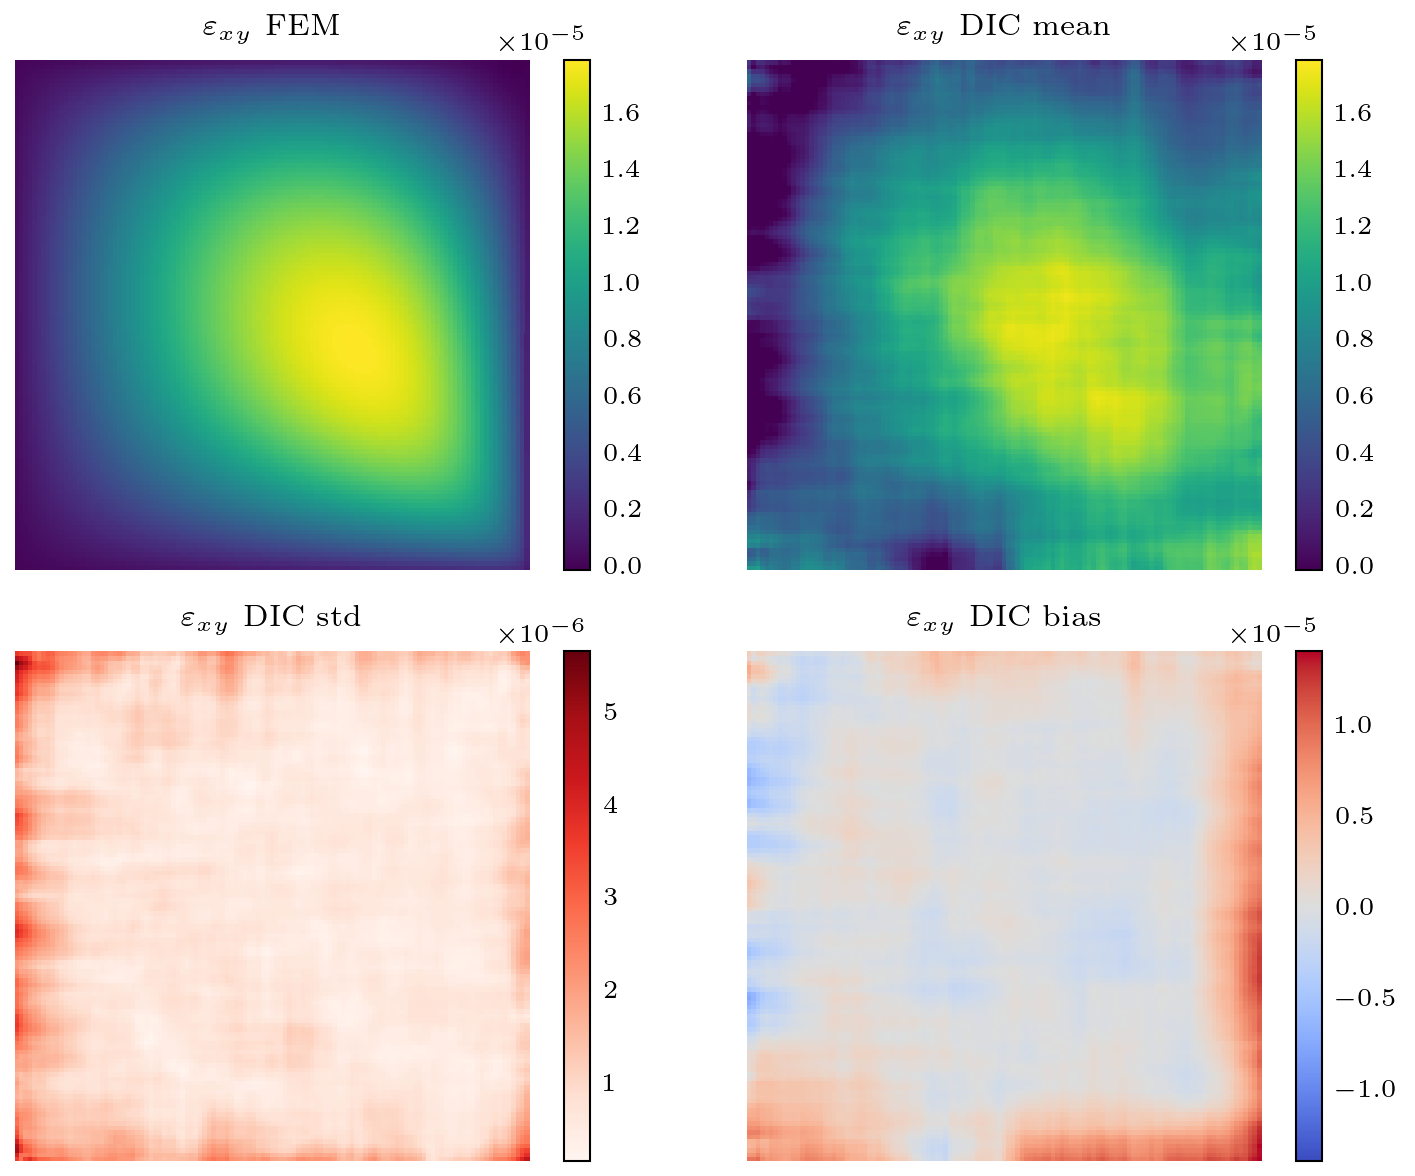

In [89]:
font_factor = 1
title_font_size = 6
axes_font_size = 6
figure_factor = 1
plt.rcParams.update({
    "font.size": title_font_size*font_factor,         # Default font size for all text
    "figure.titlesize": title_font_size*font_factor, 
    "axes.labelsize": axes_font_size*font_factor,
    "xtick.labelsize": axes_font_size*font_factor,
    "ytick.labelsize": axes_font_size*font_factor,
    "legend.fontsize": axes_font_size*font_factor,
})

camera_resolution = ["5MP","2MP","0.4MP"][1]
noise = 1
base_folder = f"data_dic/{camera_resolution}/{noise}noise/"
field_id = 4

X_dic, Y_dic, fields_mean, fields_std, fields_bias, fields_std_to_fem = compute_statistics(base_folder)
# plot_mean_std(0, X_dic, Y_dic, fields_mean, fields_std)
fig, ax = plt.subplots(2, 2, figsize=(5*figure_factor, 4*figure_factor), dpi=300)
ax = ax.flatten()
plot_mean_std(ax,field_id, X_dic, Y_dic, fields_mean, fields_std)
for i in range(4):
    ax[i].axis('off')
plt.tight_layout()

fields_name_nolatex = ["Ux", "Uy", "Exx", "Eyy", "Exy"]
fig.savefig(f"figures/{camera_resolution}_mean_std_{fields_name_nolatex[field_id]}.png", dpi=300, bbox_inches='tight')

---- no noise ----
Coord. sigma: 1.27e-03
Grid step: 5.15e-01
Rel. grid step variation: 1.028%
---- 1.5 noise ----
Coord. sigma: 1.28e-03
Grid step: 5.15e-01
Rel. grid step variation: 1.028%


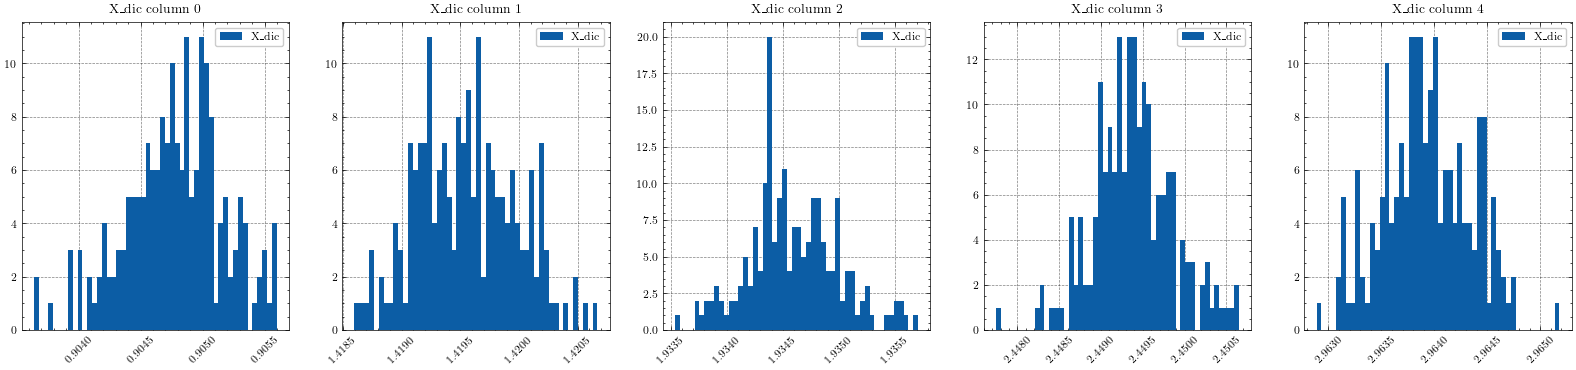

In [128]:
#Histograms of the first 5 X_dic columns
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].hist(X_dic[:,i], bins=50, label='X_dic')
    ax[i].set_title(f"X_dic column {i}")
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].legend()

print("---- no noise ----")
print(f"Coord. sigma: {np.mean(np.std(X_dic, axis=0)):0.2e}")
print(f"Grid step: {np.mean(np.diff(np.mean(X_dic, axis=0))):.2e}")
print(f"Rel. grid step variation: {np.mean(np.diff(np.mean(X_dic, axis=0)))/np.mean(np.mean(X_dic, axis=0))*100:.3f}%")

print("---- 1.5 noise ----")
print(f"Coord. sigma: {np.mean(np.std(X_dic_noise, axis=0)):0.2e}")
print(f"Grid step: {np.mean(np.diff(np.mean(X_dic_noise, axis=0))):.2e}")
print(f"Rel. grid step variation: {np.mean(np.diff(np.mean(X_dic_noise, axis=0)))/np.mean(np.mean(X_dic_noise, axis=0))*100:.3f}%")

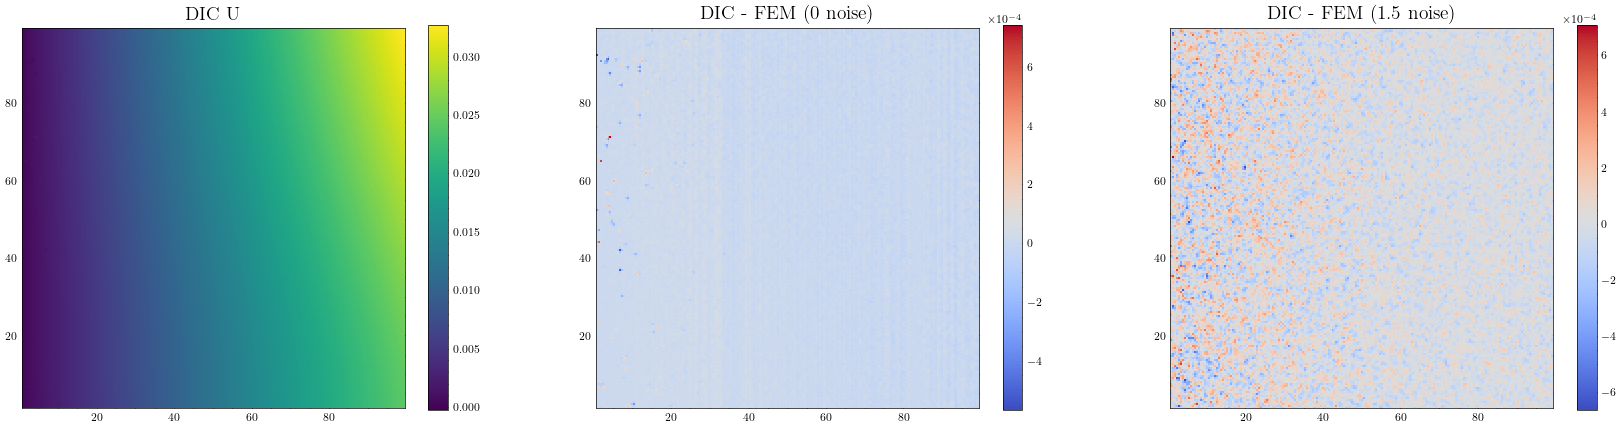

In [130]:
#extracting regular grid from DIC data

x_values = np.mean(X_dic, axis=0)
y_values = np.mean(Y_dic, axis=1)
Ux_dic_func = RegularGridInterpolator((y_values, x_values), Ux_dic, method="linear", bounds_error=False, fill_value=None)
Ux_dic_noise_func = RegularGridInterpolator((y_values, x_values), Ux_dic_noise, method="linear", bounds_error=False, fill_value=None)

X, Y = np.meshgrid(x_values, y_values)

# Interpolate DIC data to FEM grid
U_dic_interp = Ux_dic_func((Y.flatten(), X.flatten())).reshape(X.shape)
U_dic_noise_interp = Ux_dic_noise_func((Y.flatten(), X.flatten())).reshape(X.shape)



# Compute residuals (FEM - DIC)
Ux_fem = solution_fn(X.flatten(), Y.flatten())[:, 0].reshape(X.shape)

residuals =  U_dic_interp - Ux_fem
residuals_noise = U_dic_noise_interp - Ux_fem

# Plot DIC displacement
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

# DIC plot
pcolor_plot(ax[0], X, Y, U_dic_interp, "DIC U", colormap="viridis")#, cmin=0, cmax=0.015)
# Residuals plot
pcolor_plot(ax[1], X, Y, residuals, "DIC - FEM  (0 noise)", colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

# Residuals plot
pcolor_plot(ax[2], X, Y, residuals_noise, "DIC - FEM  (1.5 noise)", colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

# plt.tight_layout()
plt.show()


Alignment residual: 8.05e-05 is of order 10^-8 wich is below the noise floor


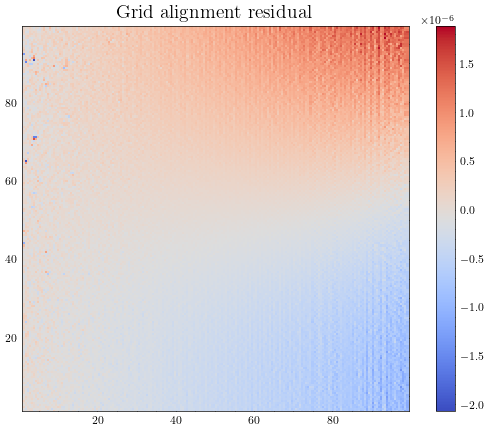

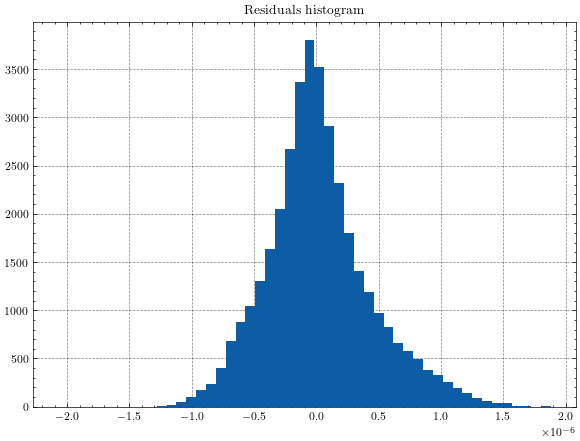

In [139]:
#alignment residual

interp_residuals = Ux_dic_func((Y_dic.flatten(), X_dic.flatten())).reshape(X_dic.shape) - Ux_dic

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = pcolor_plot(ax, X_dic, Y_dic, interp_residuals, "Grid alignment residual",colormap="coolwarm")
print(f"Alignment residual: {np.linalg.norm(interp_residuals):.2e} is of order 10^-8 wich is below the noise floor")

#histogram of the residuals
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(interp_residuals.flatten(), bins=50, label='residuals')
ax.set_title(f"Residuals histogram")
plt.show()